**Import libraries**

This section imports the necessary libraries for data manipulation and analysis.

In [303]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pychattr.channel_attribution import MarkovModel
from pychattr.channel_attribution import HeuristicModel
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import make_interp_spline

**Read the CSV and Inspect the Data**

In [304]:
df = pd.read_csv('TBA_attribution_data.csv')

In [305]:
# Inspect the structure
print(df.head())

                      cookie                  time interaction  conversion  \
0  11111FkCnDfDDf1iC97iC713B  2018-07-03T13:02:11Z  impression         0.0   
1  11111FkCnDfDDf1iC97iC713B  2018-07-17T19:15:07Z  impression         0.0   
2  11111FkCnDfDDf1iC97iC713B  2018-07-24T15:51:46Z  impression         0.0   
3  11111FkCnDfDDf1iC97iC713B  2018-07-29T07:44:51Z  impression         0.0   
4  1111nACkD9nFkBBDECD3ki11E  2018-07-03T09:44:57Z  impression         0.0   

   conversion_value         channel  
0               0.0       Instagram  
1               0.0  Online Display  
2               0.0  Online Display  
3               0.0  Online Display  
4               0.0     Paid Search  


In [306]:
#Print (num of rows, columns)
print(df.shape)

(586937, 6)


In [307]:
#Print columns and their data types
print(df.dtypes)
print(df.info()) 

cookie               object
time                 object
interaction          object
conversion          float64
conversion_value    float64
channel              object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586937 entries, 0 to 586936
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586937 non-null  object 
 1   time              586937 non-null  object 
 2   interaction       586937 non-null  object 
 3   conversion        586928 non-null  float64
 4   conversion_value  586937 non-null  float64
 5   channel           586937 non-null  object 
dtypes: float64(2), object(4)
memory usage: 26.9+ MB
None


Time Frame of Data, checking from when to when the rows are

In [308]:
min_time = df['time'].min()
max_time = df['time'].max()
print("Minimum time:", min_time)
print("Maximum time:", max_time)

Minimum time: 2018-07-01T13:13:16Z
Maximum time: 2018-07-31T23:59:30Z


Check columns values as in GROUP BY in SQL

In [309]:
for col in ['interaction', 'conversion', 'channel']:  
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("----------------")

Value counts for interaction:
interaction
impression    569286
conversion     17651
Name: count, dtype: int64
----------------
Value counts for conversion:
conversion
0.0    569277
1.0     17651
Name: count, dtype: int64
----------------
Value counts for channel:
channel
Facebook          175792
Paid Search       151485
Online Video      113350
Instagram          75227
Online Display     71083
Name: count, dtype: int64
----------------


**First Data Pre-processing task** : Determine Data types for Columns and see if anything needs to be changed.

In [310]:
df.dtypes

cookie               object
time                 object
interaction          object
conversion          float64
conversion_value    float64
channel              object
dtype: object

Given that the 'time' column seems to be carrying timestamps I would convert it to a datetime object. 
This will allow us to perform operations on the time column, like compare which timestamp is before and after each other. The current data type 'object' is more for strings than timestamps although there

In [311]:
print('before transformation \'time\' column was:', df['time'].dtypes)
df['time']=pd.to_datetime(df['time'])
#print(df['time'].tail())
print('after transdormation the type of time column:',df['time'].dtypes)

before transformation 'time' column was: object
after transdormation the type of time column: datetime64[ns, UTC]


Check for NULLs

In [312]:
null_counts = df.isnull().sum()
print(null_counts)

cookie              0
time                0
interaction         0
conversion          9
conversion_value    0
channel             0
dtype: int64


Show rows with NULL. There are 9 in conversion column so let's show these ones.

In [313]:
null_rows = df[df['conversion'].isnull()]
print(null_rows)

                           cookie                      time interaction  \
74      111f1nF77Afhf9ho7Aiff1Chh 2018-07-14 20:31:43+00:00  impression   
277     113iB9Bk33EA3nfAA9i73niki 2018-07-17 10:42:27+00:00  impression   
469     119AFB9fiFfhEB3nEfDok9hDA 2018-07-23 12:10:09+00:00  impression   
760     11BCC1Co9fk3ni1CC19AE3i3E 2018-07-03 06:25:36+00:00  impression   
1030    11D1CfBfn7o1AEE9k773CnFhA 2018-07-13 13:17:54+00:00  impression   
1218    11EBE19hkFFoihBDonhAFokn7 2018-07-17 22:53:31+00:00  impression   
115814  97oinFDfB31hDCnA9o7hk9B3f 2018-07-30 18:33:06+00:00  impression   
389170  fFnfn9oFh9DhDDkk7kAF9o1B3 2018-07-09 20:11:47+00:00  impression   
444679  i3oBCoEi1nh3hk13ACA393nFh 2018-07-02 08:47:11+00:00  impression   

        conversion  conversion_value         channel  
74             NaN               0.0    Online Video  
277            NaN               0.0        Facebook  
469            NaN               0.0        Facebook  
760            NaN           

Locate the rows with 0 and if the conversion value is 0 then it makes sense to fill the NULL in conversion to 0 as no value /money means no conversion happened. 
We see that already from the above but for demonstration purposes we use the AND operator because in real life it might be 1.

In [314]:
null_rows = df.loc[(df['conversion'].isnull()) & (df['conversion_value'] == 0)]

Locate and change WHEN conversion is null AND when conversion_value=0 then make Conversion to 0

In [315]:
#checks if the conversion column is null and the conversion_value column is 0 then it will replace the null value with 0
df.loc[(df['conversion'].isnull()) & (df['conversion_value'] == 0), 'conversion'] = 0

null_counts = df.isnull().sum()
print(null_counts)

cookie              0
time                0
interaction         0
conversion          0
conversion_value    0
channel             0
dtype: int64


**Check for Duplicates first in across ALL columns then a subset**

In [316]:
duplicate_rows = df[df.duplicated(keep=False)]

duplicate_rows = duplicate_rows.sort_values(by='time')

print(duplicate_rows)

num_duplicates = df.duplicated().sum()

print("\nNumber of Duplicate Rows:", num_duplicates)

                           cookie                      time interaction  \
251665  Cn99C7on3DioDEDofDnBCC9oD 2018-07-01 13:50:28+00:00  impression   
251666  Cn99C7on3DioDEDofDnBCC9oD 2018-07-01 13:50:28+00:00  impression   
501018  kh1nnkkf7fBiDFDAi31fBAhAo 2018-07-01 14:10:22+00:00  impression   
501017  kh1nnkkf7fBiDFDAi31fBAhAo 2018-07-01 14:10:22+00:00  impression   
542567  nk37BB1h1DACfoA9fDCo73oin 2018-07-01 14:16:43+00:00  impression   
...                           ...                       ...         ...   
527747  nCF3337fCABAoBFoBnAhfEffF 2018-07-31 09:37:36+00:00  impression   
176117  AkCBfBDEBnoCfoDFEA37f73DC 2018-07-31 10:14:55+00:00  impression   
176116  AkCBfBDEBnoCfoDFEA37f73DC 2018-07-31 10:14:55+00:00  impression   
291619  DoFB9DoCn3DB1nF9FiCkkCB17 2018-07-31 10:15:42+00:00  impression   
291620  DoFB9DoCn3DB1nF9FiCkkCB17 2018-07-31 10:15:42+00:00  impression   

        conversion  conversion_value   channel  
251665         0.0               0.0  Facebook  
2

4345 duplicates found

Remove the duplicates

In [317]:
df.drop_duplicates(inplace=True)

print("\nDuplicate Rows after removing duplicates:",df[df.duplicated()].shape)


Duplicate Rows after removing duplicates: (0, 6)


Rows that are duplicate couple with 1 conversion and 1 impresion and dropping the 'impression' one in favour of the conversion

In [318]:
duplicate_rows = df[df.duplicated(subset=['cookie', 'time'], keep=False)]

# Sort the duplicate rows by time
duplicate_rows = duplicate_rows.sort_values(by='time')

# Filter duplicate_rows where 'interaction' column is 'conversion'
print("all dup row based on cookie and time", len(duplicate_rows))
impression_duplicates = duplicate_rows[duplicate_rows['interaction'] == 'impression']

conversion_duplicates = duplicate_rows[duplicate_rows['interaction'] == 'conversion']
#print(conversion_duplicates[['time','cookie']])

# Merge and keep all columns from impression duplicates, only 'name' from conversion_duplicates
merged_df = impression_duplicates.merge(conversion_duplicates[['cookie', 'time']], on=['cookie', 'time'], how='inner')

# Print the result
print("all duplicate row based on cookie and time that are impressions",len(impression_duplicates))
print(len(conversion_duplicates))
# Print the duplicate rows
#conversion_rows=duplicate_rows[duplicate_rows['interaction']=='conversion']
#print(len(conversion_rows['interaction']=='conversion'))

#finds duplicates with same cookie and time in the intial dataframe that have an interaction with 'impression' and removes them
print("before drop",len(df))
df = df.merge(merged_df, how='left', indicator=True)
df = df[df['_merge'] == 'left_only'].drop(columns=['_merge'])
print("after drop",len(df))


duplicate_rows = df[df.duplicated(subset=['cookie', 'time'], keep=False)]
len(duplicate_rows)


all dup row based on cookie and time 1556
all duplicate row based on cookie and time that are impressions 1362
194
before drop 582592
after drop 582398


1168

After removing the ones that have an 'impression' and same timestamp with conversion let's proceed to remove the ones that have different channel.
Given the popularity of 'Facebook' as a channel I am taking this as a standard value and removing the other ones like 'Instagram'

Code belows proves that Facebook is the second most frequent channel so it will take precedence over others.

In [319]:
# Filter for rows where interaction is 'impression'
impression_rows = df[df['interaction'] == 'impression']

# Group by channel and count unique cookies
channel_cookie_counts = impression_rows.groupby('channel')['cookie'].nunique()

# Print the channel cookie counts
print("Number of unique cookies per channel where interaction is 'impression':")
print(channel_cookie_counts)

Number of unique cookies per channel where interaction is 'impression':
channel
Facebook          85430
Instagram         47956
Online Display    41292
Online Video      39721
Paid Search       86076
Name: cookie, dtype: int64


In [320]:
# Find duplicate rows based on cookie and time
duplicate_rows = df[df.duplicated(subset=['cookie', 'time'], keep=False)]

# Group by cookie and time, then aggregate channels into lists
channel_couples = duplicate_rows.groupby(['cookie', 'time'])['channel'].apply(list).reset_index(name='channels')

# Count the occurrences of each channel couple
channel_couple_counts = channel_couples['channels'].value_counts()

# Print the channel couple counts
print("\nOccurrences of each channel couple:")
print(channel_couple_counts)
#Print all that are not Facebook or Paid Search
print(duplicate_rows[(duplicate_rows['channel'] != 'Facebook') & (duplicate_rows['channel'] != 'Paid Search')][['cookie', 'time', 'channel']])
# Find duplicate rows based on cookie and time such that the channel is not 'Facebook' or 'Paid Search'
to_be_removed=duplicate_rows[(duplicate_rows['channel'] != 'Facebook') & (duplicate_rows['channel'] != 'Paid Search')][['cookie', 'time', 'channel']]



Occurrences of each channel couple:
channels
[Facebook, Instagram]            291
[Instagram, Facebook]            279
[Online Video, Facebook]           6
[Facebook, Online Video]           4
[Paid Search, Online Display]      1
[Instagram, Online Video]          1
[Online Video, Instagram]          1
[Online Display, Facebook]         1
Name: count, dtype: int64
                           cookie                      time       channel
1169    11E3f3C9AEkA37n3oC3BnhohD 2018-07-11 20:38:38+00:00  Online Video
1209    11ECBCfEFkCkCBi7n73EkkhAF 2018-07-31 06:29:24+00:00     Instagram
2818    139o3Ef9C791kB799A3Fkn3oA 2018-07-28 14:49:15+00:00     Instagram
3600    13F97oEC7DnDn9kiDh9nCCBCf 2018-07-19 11:44:16+00:00     Instagram
3758    13fCCCnn3FC3o9fDB779BhFEE 2018-07-19 08:00:11+00:00     Instagram
...                           ...                       ...           ...
577014  okfEiEFB9ohokE1FFCkBEof1f 2018-07-02 17:38:27+00:00     Instagram
577388  okk1hAkA3hfE73iD3i3nFhAo1 2018-0

Doing a left join adding an indicator _merged that will get a left_only for the ones matched in df and 'both' when it join based on same cookie, time and channel with the to_be_removed dataframe which is basically everything not facebook or paid search 

In [321]:

print('duplicates before drop:',len(df[df.duplicated(subset=['cookie', 'time'], keep=False)]))

# Merge the to_be_removed DataFrame with the original DataFrame , a LEFT JOIN
df=df.merge(to_be_removed, how='left', on=['cookie','time','channel'], indicator=True)

print("before drop",len(df))
#print(df[df['_merge'] == 'both'])

# Drop rows where the merge indicator is both meaning a match was found
df = df.drop(df[df['_merge'] == 'both'].index)

# Drop the merge indicator column
df = df.drop(columns=['_merge'])

print("after drop",len(df))


duplicates before drop: 1168
before drop 582398
after drop 581812


Final check on duplicates

In [322]:
print(len(df))
print("duplicates after drop:",len(df[df.duplicated(subset=['cookie', 'time'], keep=False)]))

581812
duplicates after drop: 0


Detect the Outliers via the Interquartile Range Method Rule

In [323]:
# Filter for rows where interaction is 'conversion', we want to exclude the ones with 0 as we want to check for outliers in terms of value of purchase
df_filtered = df[df['conversion_value'] != 0]

# Calculate Q1 and Q3 on the filtered data 
#Q1 is the value below which 25% of the data falls
Q1 = df_filtered['conversion_value'].quantile(0.25)
#Q3 is the value below which 75% of the data falls
Q3 = df_filtered['conversion_value'].quantile(0.75)
#Interquartile range
IQR = Q3 - Q1

# Define the multiplier for outliers
multiplier = 1.5

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - multiplier * IQR
upper_bound = Q3 + multiplier * IQR

# Identify outliers
# Filter for rows where conversion_value is an outlier (below lower bound or above upper bound)
outliers = df_filtered[(df_filtered['conversion_value'] < lower_bound) | (df_filtered['conversion_value'] > upper_bound)]

# Print the outliers
print("Q1 (excluding 0 values):", Q1)
print("Q3 (excluding 0 values):", Q3)
print("Lower bound (excluding 0 values):", lower_bound)
print("Upper bound (excluding 0 values):", upper_bound)
print("IQR (excluding 0 values):", IQR)
print("Outliers (excluding 0 values):")
print(outliers)

# Print the number of outliers
print("\nNumber of Outliers:", len(outliers))
len(df)

Q1 (excluding 0 values): 335.5
Q3 (excluding 0 values): 427.0
Lower bound (excluding 0 values): 198.25
Upper bound (excluding 0 values): 564.25
IQR (excluding 0 values): 91.5
Outliers (excluding 0 values):
                        cookie                      time interaction  \
943  11CFhDAEAFkf1Ah73AD77C1no 2018-07-24 19:56:55+00:00  conversion   

     conversion  conversion_value   channel  
943         1.0        10000000.0  Facebook  

Number of Outliers: 1


581812

Remove the outliers

In [324]:
# Remove outliers 
df = df.drop(outliers.index)

# Display the shape of the DataFrame after removing outliers
print("Shape of DataFrame after removing outliers:", df.shape)
len(df)
df.info()

Shape of DataFrame after removing outliers: (581811, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 581811 entries, 0 to 582397
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   cookie            581811 non-null  object             
 1   time              581811 non-null  datetime64[ns, UTC]
 2   interaction       581811 non-null  object             
 3   conversion        581811 non-null  float64            
 4   conversion_value  581811 non-null  float64            
 5   channel           581811 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 31.1+ MB


Show aggregate functions per channel

In [325]:
# Grouping by channel and counting the number of conversions
channel_stats = df[df['conversion'] == 1].groupby('channel')['conversion_value'].agg(['min', 'max', 'mean', 'median', 'count'])

# Print the results
print(channel_stats)

# Save the number of touchpoints per channel for conversion rate later on in the code
touchpoints = df.groupby('channel')['interaction'].agg('count')

# Rename the column to 'touchpoints'
touchpoints.name = 'touchpoints'

# Display the touchpoints
print(touchpoints)


                  min    max        mean  median  count
channel                                                
Facebook        244.0  518.5  381.388113   396.5   5300
Instagram       244.0  518.5  381.644162   396.5   2244
Online Display  244.0  518.5  379.246611   366.0   2139
Online Video    244.0  518.5  383.362089   396.5   3408
Paid Search     244.0  518.5  380.079503   366.0   4547
channel
Facebook          175036
Instagram          74505
Online Display     70875
Online Video      110757
Paid Search       150638
Name: touchpoints, dtype: int64


Chart to plot time series revenue per daily

conversions per channel
Facebook          5300.0
Instagram         2244.0
Online Display    2139.0
Online Video      3408.0
Paid Search       4547.0
Name: conversion, dtype: float64
Total sessions: 240107
Total revenue: 6723694.5


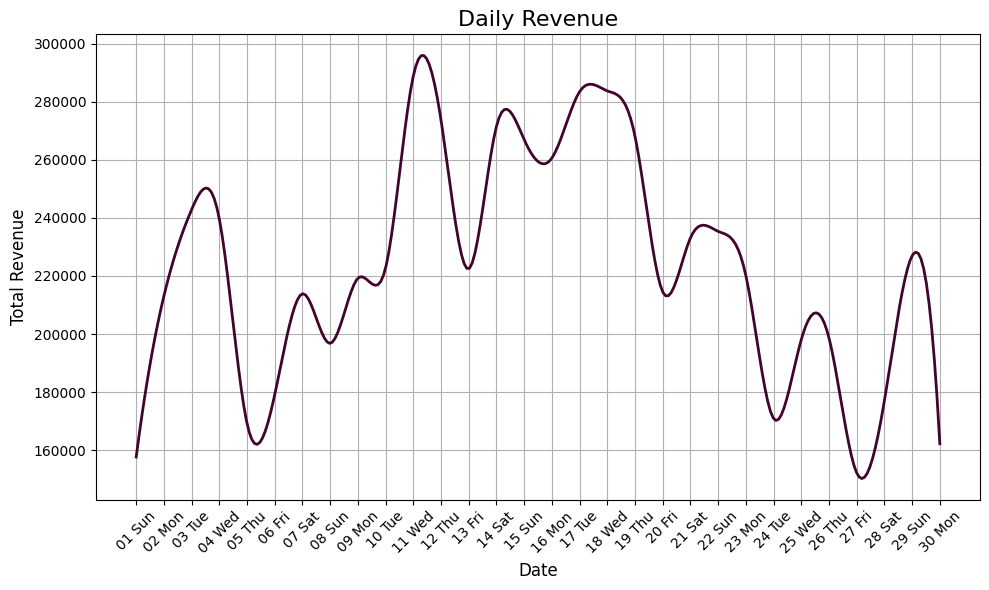

Revenue per day time
2018-07-01    157685.0
2018-07-02    213103.5
2018-07-03    242841.0
2018-07-04    239577.5
2018-07-05    169183.5
2018-07-06    179187.5
2018-07-07    213866.0
2018-07-08    196786.0
2018-07-09    219203.5
2018-07-10    222772.0
2018-07-11    288835.0
2018-07-12    273615.5
2018-07-13    222436.5
2018-07-14    271480.5
2018-07-15    266905.5
2018-07-16    260561.5
2018-07-17    283406.0
2018-07-18    283680.5
2018-07-19    268064.5
2018-07-20    214506.5
2018-07-21    233081.0
2018-07-22    235338.0
2018-07-23    220149.0
2018-07-24    170922.0
2018-07-25    198067.0
2018-07-26    198677.0
2018-07-27    152195.0
2018-07-28    177052.5
2018-07-29    226920.0
2018-07-30    162229.5
Name: conversion_value, dtype: float64
All interactions per channel channel
Facebook          175036
Instagram          74505
Online Display     70875
Online Video      110757
Paid Search       150638
Name: interaction, dtype: int64


In [326]:
print('conversions per', df.groupby('channel')['conversion'].agg('sum'))
total_sessions = df['cookie'].nunique()
print(f'Total sessions: {total_sessions}')
total_revenue = df['conversion_value'].sum()
print(f'Total revenue: {total_revenue}')
# Ensure the 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Group by date (ignoring the time component) and calculate the total revenue per day
daily_revenue = df.groupby(df['time'].dt.date)['conversion_value'].agg('sum')

# Remove the last day from the data
daily_revenue = daily_revenue.iloc[:-1]

# Smooth the line using spline interpolation
x = np.arange(len(daily_revenue))  # Create an array of indices for the x-axis
y = daily_revenue.values  # Get the revenue values
x_smooth = np.linspace(x.min(), x.max(), 300)  # Create a smoother x-axis
y_smooth = make_interp_spline(x, y)(x_smooth)  # Interpolate the y-axis values

# Plot the smoothed line
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, color='#41042C', linewidth=2)  # Smooth line without markers

# Format x-axis labels to show day of the month and day of the week
formatted_labels = [date.strftime('%d %a') for date in daily_revenue.index]  # Format as 'day of month day of week'
plt.xticks(ticks=np.arange(len(daily_revenue)), labels=formatted_labels, rotation=45)

# Add titles and labels
plt.title('Daily Revenue', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()

# Print the daily revenue
print("Revenue per day", daily_revenue)

cleanimpressions=print("All interactions per channel",df.groupby('channel')['interaction'].agg('count'))

Chart to demonstrate which channel has the most touchpoints (impressions + conversions)

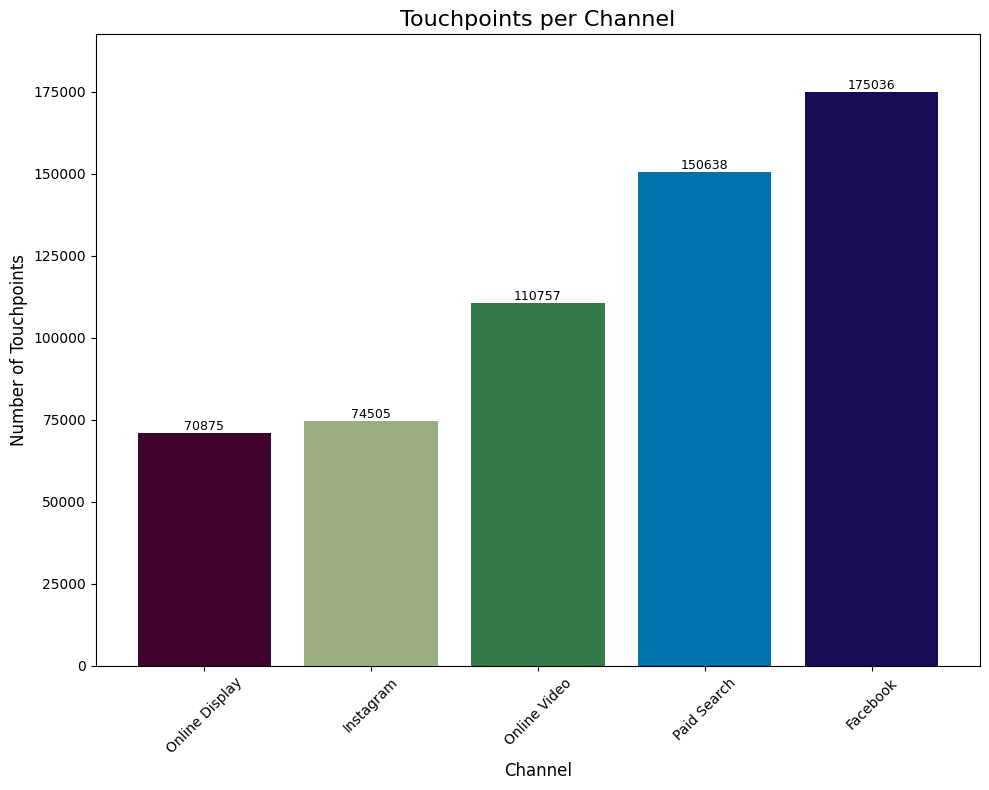

In [327]:
# Group by 'channel' and count the number of interactions
cleanimpressions = df.groupby('channel')['interaction'].agg('count').reset_index()
cleanimpressions.columns = ['channel', 'touchpoints']  # Rename columns for clarity

# Sort the DataFrame by the 'impressions' column in ascending order
cleanimpressions = cleanimpressions.sort_values(by='touchpoints', ascending=True)

# HEX codes for colours from TBAuction website
colors = ['#41042C', '#9baf7e', '#357b49', '#0073AA','#170B53']

# Plot cleanimpressions as a bar chart
ax = cleanimpressions.plot(
    x='channel',  # Use 'channel' as the x-axis
    y='touchpoints',  # Use 'impressions' as the y-axis
    kind='bar', 
    figsize=(10, 8), 
    color=colors,  # Set a custom color for the bars
    width=0.8,
    legend=False  # Hide the legend since there's only one bar type
)

# Customize x-axis labels and rotation
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Add titles and axis labels
plt.title('Touchpoints per Channel', fontsize=16)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Number of Touchpoints', fontsize=12)

# Automatically add data labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

# Adjust the y-axis range to add more space above the bars
max_y = cleanimpressions['touchpoints'].max()  # Find the maximum value in the 'impressions' column
plt.ylim(0, max_y * 1.1)  # Add 10% extra space above the tallest bar

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()

Transform the data frame to become a Path Oriented data frame to use for attribution modelling and markov chains
following the guidelines in this package : https://github.com/jmwoloso/pychattr
    "path": [
        "A >>> B >>> A >>> B >>> B >>> A",
        "A >>> B >>> B >>> A >>> A",
        "A >>> A"
    ],
    "conversions": [1, 1, 1],
    "revenue": [1, 1, 1],
    "cost": [1, 1, 1]

    There is no cost given so we will not use that one for our further analysis. Although that would be excellent for ROI calculation.

In [328]:
# Step 1: Sort by cookie and time to maintain sequence
df = df.sort_values(['cookie', 'time'])

# Step 2: Group by cookie
result = df.groupby('cookie').agg({
    # add >>> between channels as delimiter because this is a prerequiste for the library we are going to use later on 
    'channel': lambda x: ' >>> '.join(x),
    # will grab 1 if there is a conversion and 0 if there is not
    'conversion': 'max',
    # calculate the sum of conversion values = revenue
    'conversion_value': 'sum'
}).reset_index()


# Step 3: Rename columns => channel to path and conversion to conversions and conversion_value to revenue
result.rename(columns={'channel': 'path', 'conversion': 'conversions', 'conversion_value': 'revenue'}, inplace=True)

# Step 4: Drop cookie column if not needed
result = result[['path', 'conversions', 'revenue']]
# Change the data type of the conversions column to integer
result['conversions'] = result['conversions'].astype(int)
# Filter for paths with at least one conversion
pathdf=result[result['conversions']>0]
# Show the number of paths
len(pathdf)

17638

Preparing the model from pychattr following the guidelines in this package : https://github.com/jmwoloso/pychattr

In [329]:
path_feature="path"
conversion_feature="conversions"
null_feature=None
revenue_feature="revenue"
cost_feature="cost"
separator=">>>"
k_order=1
n_simulations=10000
max_steps=None
return_transition_probs=True
random_state=26

# instantiate the model
mm = MarkovModel(path_feature=path_feature,
                 conversion_feature=conversion_feature,
                 null_feature=null_feature,
                 revenue_feature=revenue_feature,
                 cost_feature=cost_feature,
                 separator=separator,
                 k_order=k_order,
                 n_simulations=n_simulations,
                 max_steps=max_steps,
                 return_transition_probs=return_transition_probs,
                 random_state=random_state)

# fit the model
mm.fit(pathdf)

In [330]:
mm.attribution_model_
mm.attribution_model_.rename(columns={
    'channel_name': 'channel',
    'total_conversions': 'markov_conversions',
    'total_revenue': 'markov_revenue'
}, inplace=True)


In [331]:
mm.attribution_model_

,channel,markov_conversions,markov_revenue
0,Paid Search,4038.791065,1.535044e+06
1,Facebook,5308.349901,2.019282e+06
2,Online Video,2788.314898,1.069637e+06
3,Instagram,3455.085852,1.315806e+06
4,Online Display,2047.458283,7.839264e+05


In [332]:
# view the transition matrix
#sorted_df = mm.transition_matrix_.sort_values(by='transition_probability', ascending=False)
#print(sorted_df)


In [333]:
# view the removal effects
#print(mm.removal_effects_)

Preparing the data for other models for first, last and linear touch

In [334]:
path_feature="path"
conversion_feature="conversions"
null_feature=None
revenue_feature="revenue"
separator=">>>"
first_touch=True
last_touch=True
linear_touch=True

# instantiate the model
hm = HeuristicModel(path_feature=path_feature,
                    conversion_feature=conversion_feature,
                    null_feature=null_feature,
                    revenue_feature=revenue_feature,
                    separator=separator,
                    first_touch=first_touch,
                    last_touch=last_touch,
                    linear_touch=linear_touch,)

# fit the model
pathdf = pathdf.reset_index(drop=True)
hm.fit(pathdf)

In [ ]:
hm.attribution_model_

          channel  first_touch_conversions  first_touch_revenue  \
0        Facebook                   5182.0            1970879.5   
1       Instagram                   2323.0             887336.5   
2  Online Display                   2160.0             818559.0   
3    Online Video                   3216.0            1233755.5   
4     Paid Search                   4757.0            1813164.0   

   last_touch_conversions  last_touch_revenue  linear_touch_conversions  \
0                  5300.0           2021357.0               5225.010197   
1                  2244.0            856409.5               2259.650533   
2                  2139.0            811208.5               2126.186673   
3                  3408.0           1306498.0               3346.348255   
4                  4547.0           1728221.5               4680.804342   

   linear_touch_revenue  ensemble_conversions  ensemble_revenue  
0          1.991754e+06          15707.010197      5.983990e+06  
1          8.6

Dropping the ensemble model

In [337]:
newhm=hm.attribution_model_.drop(columns=['ensemble_conversions','ensemble_revenue'])
newhm

,channel,first_touch_conversions,first_touch_revenue,last_touch_conversions,last_touch_revenue,linear_touch_conversions,linear_touch_revenue
0,Facebook,5182.0,1970879.5,5300.0,2021357.0,5225.010197,1.991754e+06
1,Instagram,2323.0,887336.5,2244.0,856409.5,2259.650533,8.623901e+05
2,Online Display,2160.0,818559.0,2139.0,811208.5,2126.186673,8.062198e+05
3,Online Video,3216.0,1233755.5,3408.0,1306498.0,3346.348255,1.282607e+06
4,Paid Search,4757.0,1813164.0,4547.0,1728221.5,4680.804342,1.780724e+06


Join Markov Chain result with First/Last/Linear mode to create one data frame and also adding 

In [ ]:
#left join Heuristic model with Markov model
att_model_comb=newhm.merge(mm.attribution_model_, on='channel', how='left')
print(att_model_comb)


conversion_rates=att_model_comb.merge(touchpoints, on='channel', how='left')

# Build the list of columns to divide, excluding 'touchpoints' and 'channel'
columns_to_divide = [col for col in conversion_rates.columns if col not in ['touchpoints', 'channel']]

# For each column in columns_to_divide, create a new column with '_rate' appended to the name
for col in columns_to_divide:
    conversion_rates[f"{col}_rate"] = conversion_rates[col] / conversion_rates['touchpoints']

# Drop the original columns except 'channel' and 'touchpoints'
conversion_rates = conversion_rates.drop(columns=columns_to_divide + ['touchpoints'])
print(conversion_rates)

          channel  first_touch_conversions  first_touch_revenue  \
0        Facebook                   5182.0            1970879.5   
1       Instagram                   2323.0             887336.5   
2  Online Display                   2160.0             818559.0   
3    Online Video                   3216.0            1233755.5   
4     Paid Search                   4757.0            1813164.0   

   last_touch_conversions  last_touch_revenue  linear_touch_conversions  \
0                  5300.0           2021357.0               5225.010197   
1                  2244.0            856409.5               2259.650533   
2                  2139.0            811208.5               2126.186673   
3                  3408.0           1306498.0               3346.348255   
4                  4547.0           1728221.5               4680.804342   

   linear_touch_revenue  markov_conversions  markov_revenue  
0          1.991754e+06         5308.349901    2.019282e+06  
1          8.623901e+0

,channel,first_touch_conversions_rate,first_touch_revenue_rate,last_touch_conversions_rate,last_touch_revenue_rate,linear_touch_conversions_rate,linear_touch_revenue_rate,markov_conversions_rate,markov_revenue_rate
0,Facebook,0.029605,11.259852,0.030279,11.548236,0.029851,11.379109,0.030327,11.536381
1,Instagram,0.031179,11.909758,0.030119,11.494658,0.030329,11.574929,0.046374,17.660635
2,Online Display,0.030476,11.549333,0.030180,11.445623,0.029999,11.375236,0.028888,11.060689
3,Online Video,0.029037,11.139300,0.030770,11.796076,0.030213,11.580373,0.025175,9.657509
4,Paid Search,0.031579,12.036564,0.030185,11.472680,0.031073,11.821210,0.026811,10.190283


**Plotting based on Attribution method**

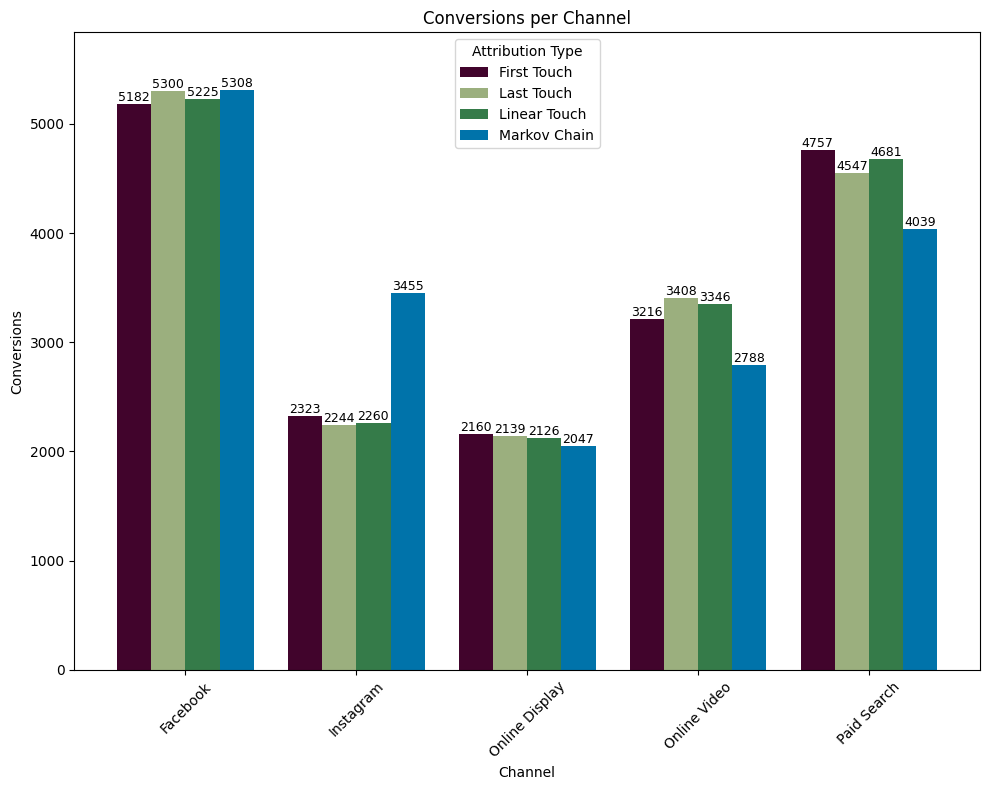

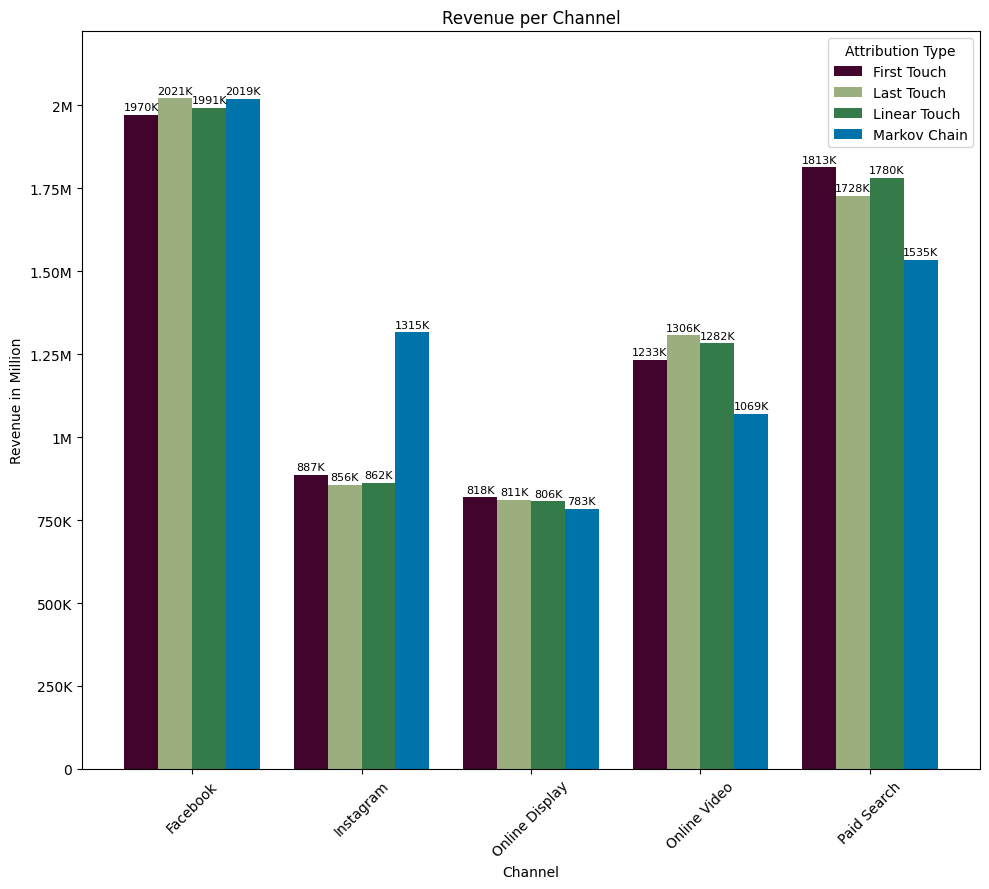

In [339]:
# Plot Conversions per Channel

# HEX codes for colours from TBAuction website
colors = ['#41042C', '#9baf7e', '#357b49', '#0073AA']

# Define the columns to plot and their corresponding display names
conversions = ['first_touch_conversions', 'last_touch_conversions', 'linear_touch_conversions', 'markov_conversions']
conversion_labels = ['First Touch', 'Last Touch', 'Linear Touch', 'Markov Chain']  # Custom labels for the legend

# Create the grouped bar plot
ax = att_model_comb[conversions].plot(
    kind='bar', 
    figsize=(10, 8), 
    width=0.8,
    color=colors
)

# Customize x-axis labels and rotation
plt.xticks(range(len(att_model_comb)), att_model_comb['channel'], rotation=45)

# Add titles and axis labels
plt.title('Conversions per Channel')
plt.ylabel('Conversions')
plt.xlabel('Channel')

# Add a legend with custom labels
plt.legend(conversion_labels, title="Attribution Type")

# Automatically add data labels to each bar
for container in ax.containers:   
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)  # fmt='%.0f' => formats the data labels as integers (no decimal places)

# Adjust the y-axis range to add more space above the bars
max_y = max([bar.get_height() for container in ax.containers for bar in container])  # Find the tallest bar
plt.ylim(0, max_y * 1.1)  # Add 10% extra space above the tallest bar

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()



# Plot revenue

# Define a function to format the y-axis labels
def format_yaxis(value, tick_number):
    if value >= 1_000_000:  # Format as millions
        if value % 1_000_000 == 0:  # Check if it's an exact multiple of 1M
            return f'{int(value / 1_000_000)}M'  # Display as a whole number (e.g., 1M, 2M)
        else:
            return f'{value / 1_000_000:.2f}M'  # Display fractional millions (e.g., 1.25M)
    elif value >= 1_000:  # Format as thousands
        return f'{int(value / 1_000)}K'
    else:  # Keep as is for smaller values
        return f'{int(value)}'

revenue = ['first_touch_revenue', 'last_touch_revenue', 'linear_touch_revenue', 'markov_revenue']
revenue_labels = ['First Touch', 'Last Touch', 'Linear Touch', 'Markov Chain']  # Custom labels for the legend
ax = att_model_comb[revenue].plot(
    kind='bar', 
    figsize=(10, 9), 
    width=0.8, 
    color=colors)

# Customize x-axis labels and rotation
plt.xticks(range(len(att_model_comb)), att_model_comb['channel'], rotation=45)

# Add titles and axis labels
plt.title('Revenue per Channel')
plt.ylabel('Revenue in Million')
plt.xlabel('Channel')

# Add a legend with custom labels
plt.legend(revenue_labels, title="Attribution Type")


# Automatically add data labels, transformed to 'K'
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{int(label / 1000)}K' for label in container.datavalues],  # Divides by 1000 the revenue value and appends a 'K' to each label
        label_type='edge',
        padding=2,
        fontsize=8
    )

# Adjust the y-axis range to add more space above the bars
max_y = max([bar.get_height() for container in ax.containers for bar in container])  # Find the tallest bar
plt.ylim(0, max_y * 1.1)  # Add 20% extra space above the tallest bar

# Apply the custom y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Plotting Conversion rate per Channel

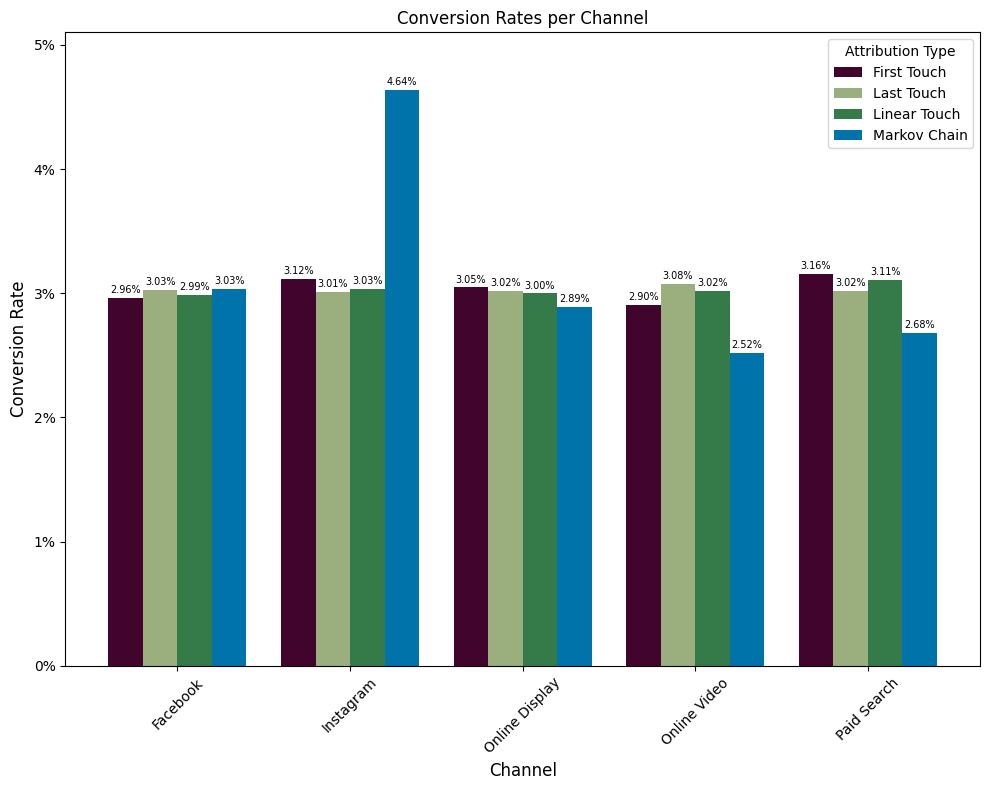

In [340]:
# Define a function to format the y-axis labels
def format_yaxis(value, tick_number):
    return f'{value * 100:.0f}%'  # Multiply by 100 and format as an integer with a '%' symbol

# Extract the columns with _rate to plot
rate_columns = ['first_touch_conversions_rate','last_touch_conversions_rate','linear_touch_conversions_rate','markov_conversions_rate']
rate_labels = ['First Touch', 'Last Touch', 'Linear Touch', 'Markov Chain']  # Custom labels for the legend

# Create the grouped bar plot
ax = conversion_rates[rate_columns].plot(
    kind='bar',
    figsize=(10, 8),
    width=0.8,
    color=colors[:len(rate_columns)]  # Ensure proper number of colors
)

# Set the x-tick labels based on 'channel'
plt.xticks(
    ticks=range(len(conversion_rates)),  # Positions for x-ticks
    labels=conversion_rates['channel'],  # Channel names from DataFrame
    rotation=45  # Rotate channel names for readability
)

# Add a title, x-label, and y-label
plt.title('Conversion Rates per Channel')
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)

# Add a legend for the rate columns
plt.legend(rate_labels, title="Attribution Type", fontsize=10)

# Automatically add data labels to the bars
for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{value * 100:.2f}%' for value in container.datavalues],  # Multiply values by 100 and add '%' symbol
                 label_type='edge',
                 padding=2,
                 fontsize=7)

# Adjust the y-axis range to add more space above the bars
max_y = max([bar.get_height() for container in ax.containers for bar in container])  # Find the maximum bar height
plt.ylim(0, max_y * 1.1)  # Set the y-axis range to 10% higher than the tallest bar

# Apply the custom y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()